# Airbnb Price Prediction (London) By Dev Sehgal

This notebook explores the prediction of Airbnb listing prices in London using a machine learning regression model.

The goal is to build a model that can estimate listing prices based on various factors such as room type, location, availability, and host information, and then evaluate its performance.

We use a Random Forest Regressor, a popular ensemble learning method that combines many decision trees to improve prediction accuracy and control overfitting.

What This Notebook Covers
	•	Data cleaning and preprocessing including encoding categorical features and handling missing values.
	•	Engineering features such as location-based weights derived from borough house prices and zonal encoding of geographic coordinates.
	•	Training the Random Forest regression model on log-transformed prices to address skewness in pricing data.
	•	Evaluating the model using metrics like Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R² score.
	•	Visualizing actual vs predicted prices to assess model performance across the price range.

ALL DATA IS PROVIDED BY insideairbnb.com, you can find datasets for specific cities at: https://insideairbnb.com/get-the-data/
You can find the London specific dataset there too, or on the github repo



Price Prediction (Using Regression) based on property attributes to predict a price

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df = pd.read_csv("listings.csv")

#only rows with prices < 500 for cleaner learning - Eliminates Outliers
df = df[df["price"] < 500]

#drop rows with missing values in required columns
df = df.dropna(subset=["room_type", "minimum_nights", "number_of_reviews", "availability_365", "price"])
# Convert room type into numeric categories
df["room_type_encoded"] = df["room_type"].astype("category").cat.codes
# Features (X) and Target (y)
X = df[["room_type_encoded", "minimum_nights", "number_of_reviews", "availability_365"]]
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [3]:
y_pred = model.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
rmse = np.sqrt(mse)
print(f"Average Prediction Error (RMSE): £{rmse:.2f}") #How far the model is off (prediction) vs actual average
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 6941.08
Average Prediction Error (RMSE): £83.31
R² Score: 0.18


We run into our first issue with this basic model - The variation in 0.18, so while it is not randomly guessing pricing, it is far from perfect (1.0). We can strengthen the model by adding more attributes, for example taking into account location, properties closer to London's Zone 1 will have a higher daily rate, even if it is a smaller room type (ie a single room can cost just as much as a house in Zone 5+ per night).

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Filter out extreme prices and drop missing values
df = pd.read_csv("listings.csv")
df = df[df["price"] < 500]
df = df.dropna(subset=[
    "room_type", "minimum_nights", "number_of_reviews",
    "availability_365", "price", "latitude", "longitude"
])

# Convert room type into numeric categories
df["room_type_encoded"] = df["room_type"].astype("category").cat.codes

# Define features and target (NOW includes location)
X = df[[
    "room_type_encoded",
    "minimum_nights",
    "number_of_reviews",
    "availability_365",
    "latitude",
    "longitude"
]]
y = df["price"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict + evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"Average Prediction Error (RMSE): £{rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 4510.16
Average Prediction Error (RMSE): £67.16
R² Score: 0.47


The model now has an improved with a variation of 0.47, which fits into a suitable score for a real world model.
It is best not to let R² exceed 0.7, as the model is most likely memorising instead of learning (overfitting), leading
to poor correlations with the test data. 

First Test: Manual Listing Prediction

Below we have an example listing (It is found in the csv), we will now enter this test. 
We ensured the model did not overfit, as this exact listing would be retrieved (due to memorisation instead of learning).

**Listing Details:**

- **Room Type:** Private room
- **Minimum Nights:** 1
- **Number of Reviews:** 51
- **Availability (days/year):** 344
- **Latitude:** 51.56861
- **Longitude:** -0.1127

We pass only these attributes into the model and record its prediction below. 
The actual price of the room is £57, let's see what the model predicts the price to be. 

In [7]:
import pandas as pd

X_manual = pd.DataFrame([{
    "room_type_encoded": 1,  #Assuming 'Private room' = 1
    "minimum_nights": 1,
    "number_of_reviews": 51,
    "availability_365": 344,
    "latitude": 51.56861,
    "longitude": -0.1127
}])

# Get prediction
predicted_price = model.predict(X_manual)[0]
print(f"Predicted Price: £{predicted_price:.2f}")

Predicted Price: £133.33


The predicted Price of £133.33 is nowhere close to the actual price of £57. Now do remember that the model 
has an Average Prediction Error (RMSE) of £67.16 which may explain the mishap. Subtracting the RMSE from
the models predicted price (£133.33) gives us the price of £66.17 which is not too bad of a prediction (from
the actual £57).  

Some reasons could be because we weigh importance on certain factors more than others. For example adding too
much significance on the long/latitude which as mentioned may increase price if the property is more central, but
certain inner city areas may actually have lower property values due to factors such as crime or economic decline. 


Before I implement these said changes, I will provide test data of a more expensive room and see if subtracting the RMSE
will provide a realistic value. 

This listing is a premium penthouse in Fitzrovia, Camden (Zone 1). It is a full flat
and should command a significantly higher price than simpler rooms.

**Listing Features:**
- Entire home/apt
- 3 minimum nights
- 67 reviews
- Availability: 11 days/year
- Central coordinates: (51.52197, -0.14035)

The actual price is **£275**, and we’ll now see what the model predicts.

In [16]:
X_expensive = pd.DataFrame([{
    "room_type_encoded": 0,  #Entire home/apt
    "minimum_nights": 3,
    "number_of_reviews": 67,
    "availability_365": 11,
    "latitude": 51.52197,
    "longitude": -0.14035
}])

predicted_price_expensive = model.predict(X_expensive)[0]
print(f"Predicted Price: £{predicted_price_expensive:.2f}")

Predicted Price: £195.06


£195.06 + RMSE (£67.16) = £262.22 
This is close to the actual £275 rate, bare in mind the RMSE being the variance can added or subtracted from 
the prediction model's output. 

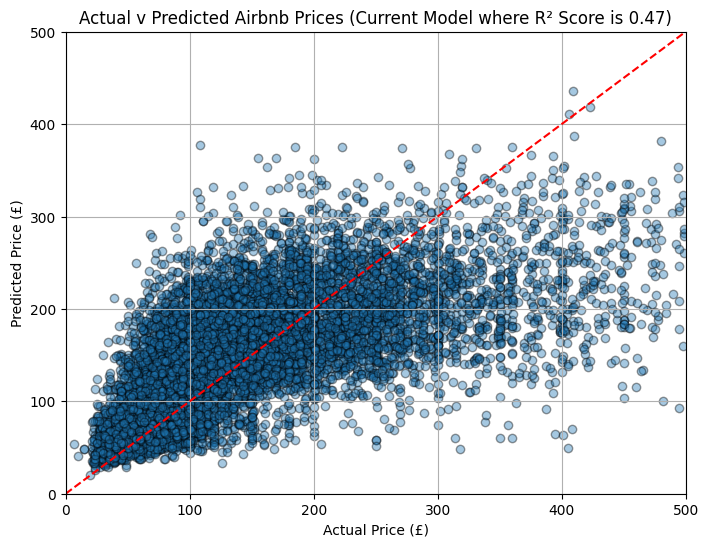

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolors='k')
plt.plot([0, 500], [0, 500], 'r--')  # Reference line: perfect prediction
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Actual v Predicted Airbnb Prices (Current Model where R² Score is 0.47)")
plt.grid(True)
plt.show()

The model is clearly failing as get into the higher price ranges by severly undermining the actual value with its prediction. 

There are certain fields the model is not using which could prove useful in modelling predictions. For example, we do not use the 
'neighbourhood' field but this could prove a 'weight' in which listings from certain boroughs in London can factor their price. It is worthwhile mentioning, London's boroughs can span large geographic areas, which different levels of economic power which directly affects prices.

You can view average London borough house prices at: https://www.twindig.com/market-views/london-house-prices 
It should also be noted I am not going to engineer fields for this model and only work with fields avaliable in the csv. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("listings.csv")
df = df[df["price"] < 500]
df = df.dropna(subset=[
    "room_type", "neighbourhood", "minimum_nights", "number_of_reviews",
    "availability_365", "price", "latitude", "longitude", 
    "reviews_per_month", "calculated_host_listings_count"
])

df["room_type_encoded"] = df["room_type"].astype("category").cat.codes

#NEW MODEL ADDS 'WEIGHT' TO BOROUGHS - 1: Higher Price, 0: Lower Prices
borough_weight_map = {
    "Kensington and Chelsea": 1.00,
    "Camden": 0.85,
    "City of Westminster": 0.83,
    "City of London": 0.82,
    "Richmond upon Thames": 0.70,
    "Hammersmith and Fulham": 0.70,
    "Islington": 0.60,
    "Hackney": 0.55,
    "Wandsworth": 0.53,
    "Inner London": 0.52,
    "Haringey": 0.50,
    "Barnet": 0.49,
    "Merton": 0.48,
    "Lambeth": 0.46,
    "Kingston upon Thames": 0.45,
    "Ealing": 0.43,
    "London": 0.42,
    "Brent": 0.41,
    "Southwark": 0.39,
    "Waltham Forest": 0.38,
    "Harrow": 0.37,
    "Tower Hamlets": 0.37,
    "Bromley": 0.36,
    "Outer London": 0.35,
    "Redbridge": 0.32,
    "Lewisham": 0.31,
    "Hounslow": 0.30,
    "Hillingdon": 0.30,
    "Enfield": 0.28,
    "Greenwich": 0.27,
    "Sutton": 0.27,
    "Havering": 0.26,
    "Croydon": 0.25,
    "Bexley": 0.22,
    "Newham": 0.20,
    "Barking and Dagenham": 0.00
}

df["borough_weight"] = df["neighbourhood"].map(borough_weight_map)
df = df.dropna(subset=["borough_weight"])

X = df[[
    "room_type_encoded",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "latitude",
    "longitude",
    "borough_weight" #New Factor
]]
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"RMSE (Average Prediction Error): £{rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 3722.86
RMSE (Average Prediction Error): £61.02
R² Score: 0.48


Adding this weighted score has made minimal improvement, with the variance (Δ0.1) but has reduced the RMSE value from £67.16 to £61.02. 
Predictions are now £6.14 more accurate. Let's plot this change below:

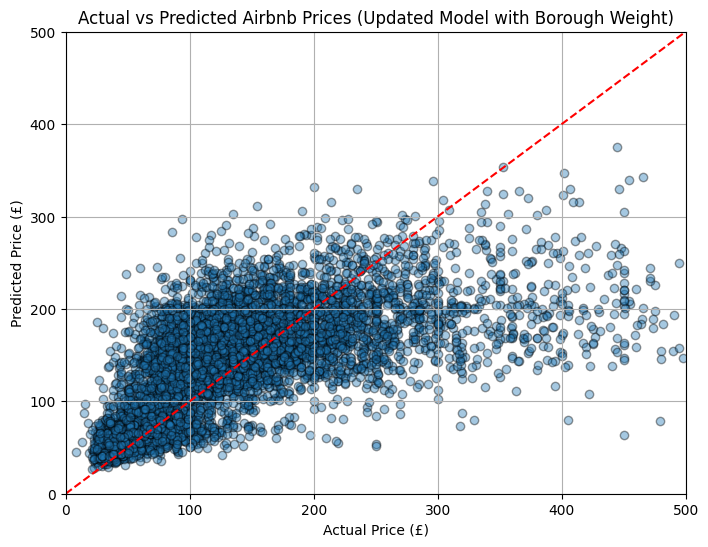

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolors='k')
plt.plot([0, 500], [0, 500], 'r--')  # Perfect prediction line
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Actual vs Predicted Airbnb Prices (Updated Model with Borough Weight)")
plt.grid(True)
plt.show()

The model has visibly been improved - Especially when the model predicted a much higher price than it actually was, it has taken the value closer to the model line. Notice how there are less scattered values aboe the £300 prediction line compared to our old model. Data is now more narrow and easily maps to the centre line.

We still want to make the model a bit more accurate, just like when we added context to the 'boroughs', based on housing valuations, we can do the same for other factors like the long/latitude. We can use Zonal Encoding to create 'Zones', the new model below incoporates this below.

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load and clean data
df = pd.read_csv("listings.csv")
df = df[df["price"] < 500]
df = df.dropna(subset=[
    "room_type", "neighbourhood", "minimum_nights", "number_of_reviews",
    "availability_365", "price", "latitude", "longitude", 
    "reviews_per_month", "calculated_host_listings_count"
])

df["room_type_encoded"] = df["room_type"].astype("category").cat.codes

borough_weight_map = {
    "Kensington and Chelsea": 1.00,
    "Camden": 0.85,
    "City of Westminster": 0.83,
    "City of London": 0.82,
    "Richmond upon Thames": 0.70,
    "Hammersmith and Fulham": 0.70,
    "Islington": 0.60,
    "Hackney": 0.55,
    "Wandsworth": 0.53,
    "Inner London": 0.52,
    "Haringey": 0.50,
    "Barnet": 0.49,
    "Merton": 0.48,
    "Lambeth": 0.46,
    "Kingston upon Thames": 0.45,
    "Ealing": 0.43,
    "London": 0.42,
    "Brent": 0.41,
    "Southwark": 0.39,
    "Waltham Forest": 0.38,
    "Harrow": 0.37,
    "Tower Hamlets": 0.37,
    "Bromley": 0.36,
    "Outer London": 0.35,
    "Redbridge": 0.32,
    "Lewisham": 0.31,
    "Hounslow": 0.30,
    "Hillingdon": 0.30,
    "Enfield": 0.28,
    "Greenwich": 0.27,
    "Sutton": 0.27,
    "Havering": 0.26,
    "Croydon": 0.25,
    "Bexley": 0.22,
    "Newham": 0.20,
    "Barking and Dagenham": 0.00
}

df["borough_weight"] = df["neighbourhood"].map(borough_weight_map)
df = df.dropna(subset=["borough_weight"])

#ZONAL ENCODING FOR THE NEW MODEL HERE
df["lat_zone"] = df["latitude"].round(2)
df["lon_zone"] = df["longitude"].round(2)

#Encode lat/lon zones as categorical codes
df["lat_zone_encoded"] = df["lat_zone"].astype("category").cat.codes
df["lon_zone_encoded"] = df["lon_zone"].astype("category").cat.codes

# update feature selection
X = df[[
    "room_type_encoded",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "borough_weight",
    "lat_zone_encoded",
    "lon_zone_encoded"
]]
y = df["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"RMSE (Average Prediction Error): £{rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 3839.28
RMSE (Average Prediction Error): £61.96
R² Score: 0.46


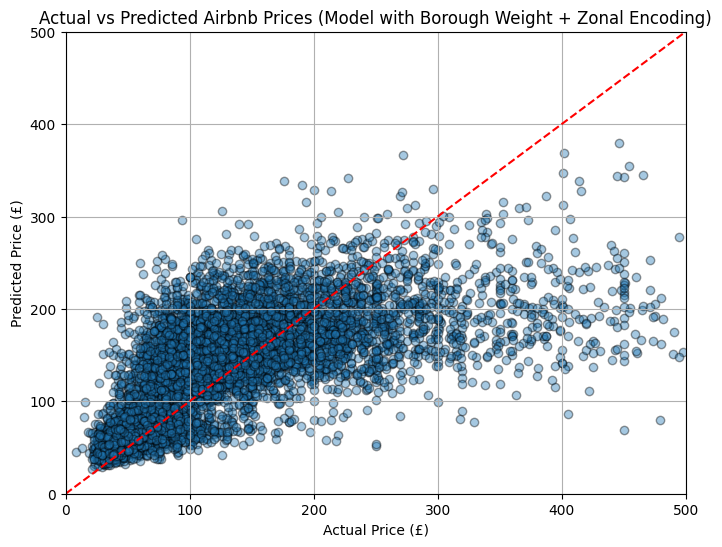

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, edgecolors='k')
plt.plot([0, 500], [0, 500], 'r--')  # Perfect prediction line
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Actual vs Predicted Airbnb Prices (Model with Borough Weight + Zonal Encoding)")
plt.grid(True)
plt.show()

The implementation of Zonal Encoding does not make too much of a difference in the prediction model. A bias with the model could be a key reason this model may be providing unstable predictions. It is clear the model is biased to predicting prices to be lower for listings which are on the higher end spectrum (actual price). 

This bias is a common issue with regression models which model sweked data such as prices (ie. Expensive listings that are outliers can push the average price up). To fix this, we can transform prices using log(price + 1) and then using exponents, you can scale back. Helps fit expensive listings better. 

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("listings.csv")
df = df[df["price"] < 500]
df = df.dropna(subset=[
    "room_type", "neighbourhood", "minimum_nights", "number_of_reviews",
    "availability_365", "price", "latitude", "longitude", 
    "reviews_per_month", "calculated_host_listings_count"
])

df["room_type_encoded"] = df["room_type"].astype("category").cat.codes

borough_weight_map = {
    "Kensington and Chelsea": 1.00,
    "Camden": 0.85,
    "City of Westminster": 0.83,
    "City of London": 0.82,
    "Richmond upon Thames": 0.70,
    "Hammersmith and Fulham": 0.70,
    "Islington": 0.60,
    "Hackney": 0.55,
    "Wandsworth": 0.53,
    "Inner London": 0.52,
    "Haringey": 0.50,
    "Barnet": 0.49,
    "Merton": 0.48,
    "Lambeth": 0.46,
    "Kingston upon Thames": 0.45,
    "Ealing": 0.43,
    "London": 0.42,
    "Brent": 0.41,
    "Southwark": 0.39,
    "Waltham Forest": 0.38,
    "Harrow": 0.37,
    "Tower Hamlets": 0.37,
    "Bromley": 0.36,
    "Outer London": 0.35,
    "Redbridge": 0.32,
    "Lewisham": 0.31,
    "Hounslow": 0.30,
    "Hillingdon": 0.30,
    "Enfield": 0.28,
    "Greenwich": 0.27,
    "Sutton": 0.27,
    "Havering": 0.26,
    "Croydon": 0.25,
    "Bexley": 0.22,
    "Newham": 0.20,
    "Barking and Dagenham": 0.00
}

df["borough_weight"] = df["neighbourhood"].map(borough_weight_map)
df = df.dropna(subset=["borough_weight"])

df["lat_zone"] = df["latitude"].round(2)
df["lon_zone"] = df["longitude"].round(2)

df["lat_zone_encoded"] = df["lat_zone"].astype("category").cat.codes
df["lon_zone_encoded"] = df["lon_zone"].astype("category").cat.codes

X = df[[
    "room_type_encoded",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "borough_weight",
    "lat_zone_encoded",
    "lon_zone_encoded"
]]
y = np.log1p(df["price"])  #log transform 

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#back-transform predictions
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  #inverse log transform

mse = mean_squared_error(np.expm1(y_test), y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"RMSE (Average Prediction Error): £{rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 3798.97
RMSE (Average Prediction Error): £61.64
R² Score: 0.47


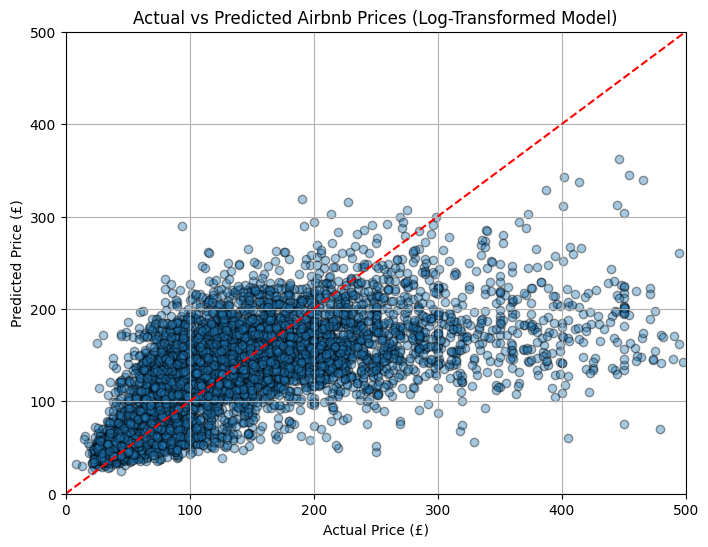

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_test), y_pred, alpha=0.4, edgecolors='k')
plt.plot([0, 500], [0, 500], 'r--')  # Perfect prediction line
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Actual vs Predicted Airbnb Prices (Log-Transformed Model)")
plt.grid(True)
plt.show()

R² Score has improved ever so slightly at 0.47, but still is failing to properly predict higher end values. The best approach is to cap the model to only predict properties below a threshold - say £300. 

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

df = pd.read_csv("listings.csv")
df = df[df["price"] < 300]
df = df.dropna(subset=[
    "room_type", "neighbourhood", "minimum_nights", "number_of_reviews",
    "availability_365", "price", "latitude", "longitude", 
    "reviews_per_month", "calculated_host_listings_count"
])

df["room_type_encoded"] = df["room_type"].astype("category").cat.codes

borough_weight_map = {
    "Kensington and Chelsea": 1.00,
    "Camden": 0.85,
    "City of Westminster": 0.83,
    "City of London": 0.82,
    "Richmond upon Thames": 0.70,
    "Hammersmith and Fulham": 0.70,
    "Islington": 0.60,
    "Hackney": 0.55,
    "Wandsworth": 0.53,
    "Inner London": 0.52,
    "Haringey": 0.50,
    "Barnet": 0.49,
    "Merton": 0.48,
    "Lambeth": 0.46,
    "Kingston upon Thames": 0.45,
    "Ealing": 0.43,
    "London": 0.42,
    "Brent": 0.41,
    "Southwark": 0.39,
    "Waltham Forest": 0.38,
    "Harrow": 0.37,
    "Tower Hamlets": 0.37,
    "Bromley": 0.36,
    "Outer London": 0.35,
    "Redbridge": 0.32,
    "Lewisham": 0.31,
    "Hounslow": 0.30,
    "Hillingdon": 0.30,
    "Enfield": 0.28,
    "Greenwich": 0.27,
    "Sutton": 0.27,
    "Havering": 0.26,
    "Croydon": 0.25,
    "Bexley": 0.22,
    "Newham": 0.20,
    "Barking and Dagenham": 0.00
}

df["borough_weight"] = df["neighbourhood"].map(borough_weight_map)
df = df.dropna(subset=["borough_weight"])

df["lat_zone"] = df["latitude"].round(2)
df["lon_zone"] = df["longitude"].round(2)

df["lat_zone_encoded"] = df["lat_zone"].astype("category").cat.codes
df["lon_zone_encoded"] = df["lon_zone"].astype("category").cat.codes

X = df[[
    "room_type_encoded",
    "minimum_nights",
    "number_of_reviews",
    "reviews_per_month",
    "calculated_host_listings_count",
    "availability_365",
    "borough_weight",
    "lat_zone_encoded",
    "lon_zone_encoded"
]]
y = np.log1p(df["price"])  #log transform 

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#back-transform predictions
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)  #inverse log transform

mse = mean_squared_error(np.expm1(y_test), y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"RMSE (Average Prediction Error): £{rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 1944.06
RMSE (Average Prediction Error): £44.09
R² Score: 0.52


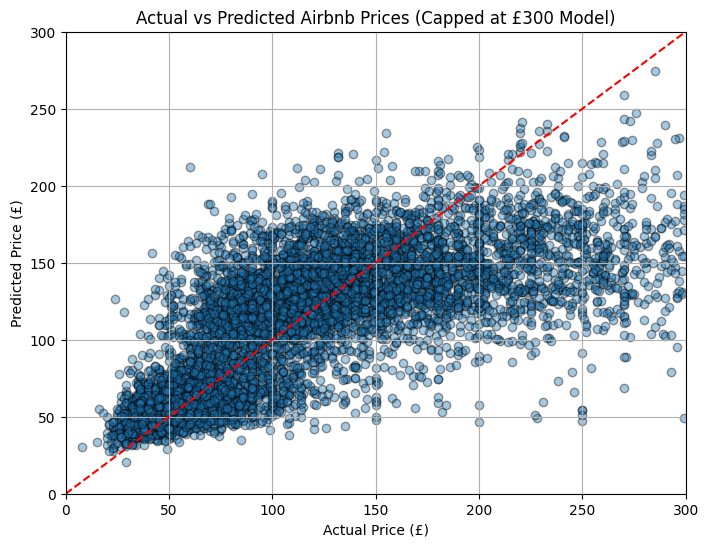

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(np.expm1(y_test), y_pred, alpha=0.4, edgecolors='k')
plt.plot([0, 300], [0, 300], 'r--')  # Perfect prediction line for capped price
plt.xlim(0, 300)
plt.ylim(0, 300)
plt.xlabel("Actual Price (£)")
plt.ylabel("Predicted Price (£)")
plt.title("Actual vs Predicted Airbnb Prices (Capped at £300 Model)")
plt.grid(True)
plt.show()

With a lower RMSE, and a higher variation of 0.52, the model is better at predicting listings in where the actual price is below £300. The model struggles on skewed data (specifically on data where the actual price is higher). 